# Build regression models

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from joblib import Parallel, delayed
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

d = './raw_data/'

In [2]:
# Import data
with open('processed_data/train_build.pkl', 'rb') as filename:  
    processed_data = pickle.load(filename)

with open('processed_data/test_build.pkl', 'rb') as filename:  
    test_data = pickle.load(filename)

In [3]:
predictors = ['log_adjusted_budget', 'avg_wroi_similar_overview',
              'avg_wroi_director_id_1',
              'avg_wroi_actor_id_1', 'avg_wroi_actor_id_2', 'avg_wroi_actor_id_3',
              'avg_wroi_genre_name_1', 'avg_wroi_genre_name_2', 'avg_wroi_genre_name_3', 
              'avg_wroi_production_company_1','avg_wroi_production_company_2', 'avg_wroi_production_company_3',
              'avg_rating_director_id_1',
              'avg_rating_actor_id_1', 'avg_rating_actor_id_2', 'avg_rating_actor_id_3',
              'avg_rating_genre_name_1', 'avg_rating_genre_name_2','avg_rating_genre_name_3', 
              'avg_rating_production_company_1','avg_rating_production_company_2', 'avg_rating_production_company_3',
              'avg_wroi_top_cast_id', 'avg_wroi_genres_list', 'avg_wroi_top_production_companies', 
              'avg_rating_top_cast_id',	'avg_rating_genres_list', 'avg_rating_top_production_companies'
             ]
outputs = ['log_wroi']

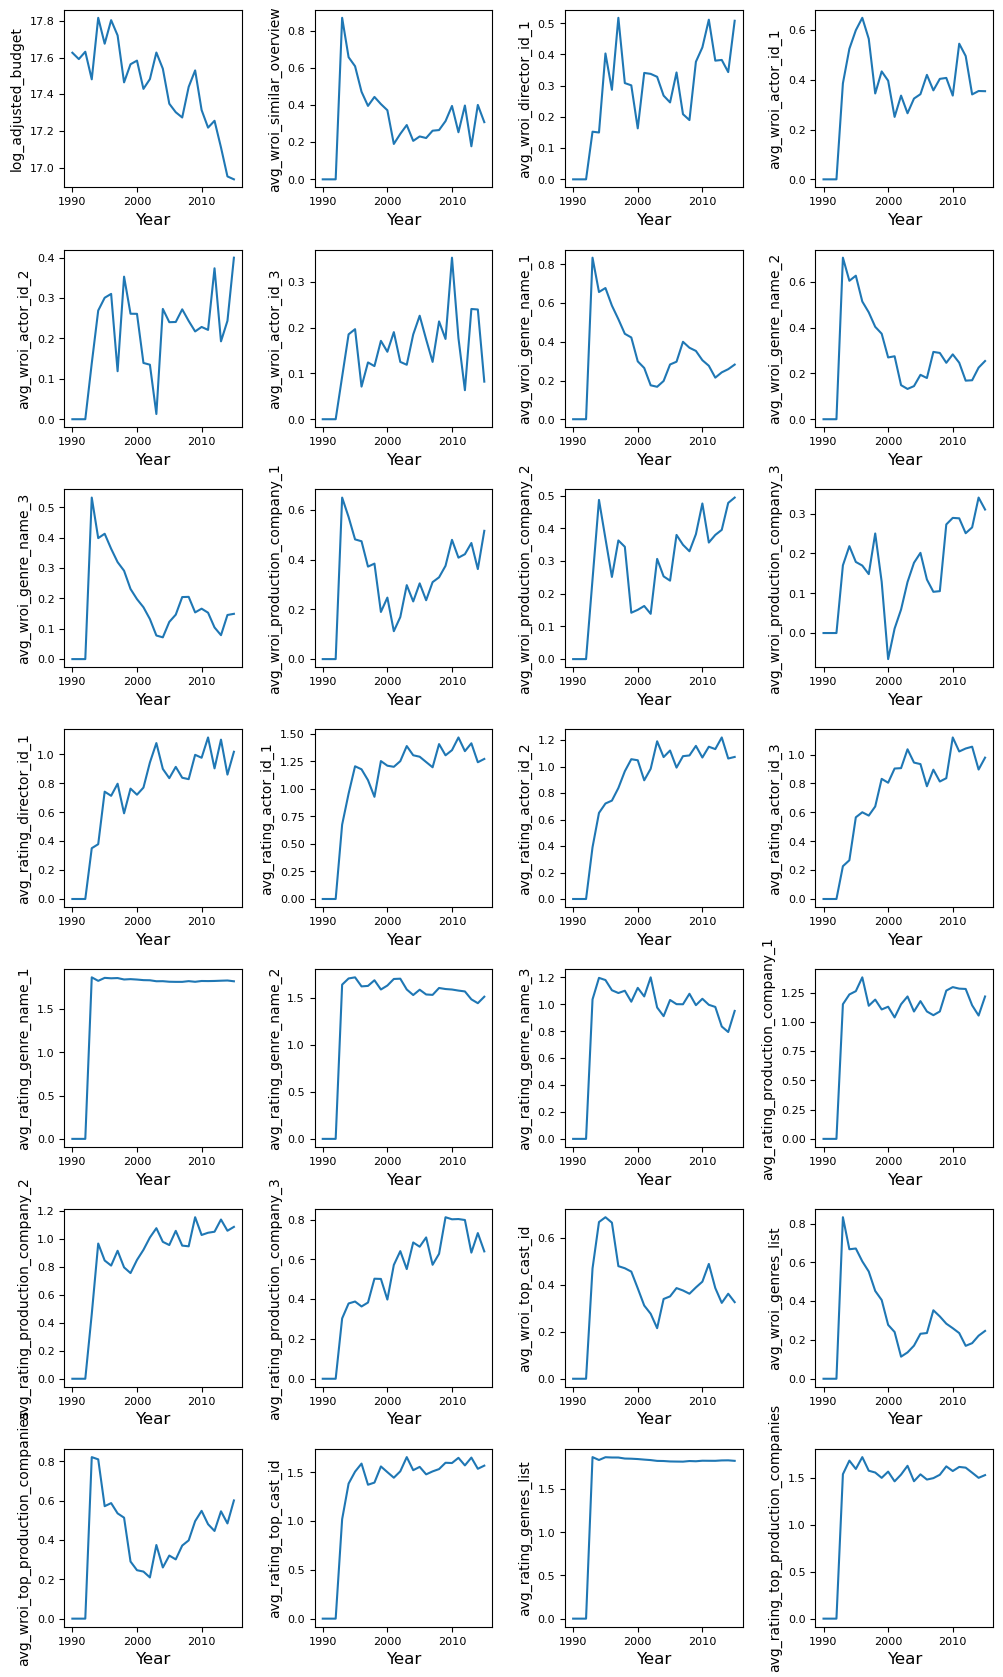

In [4]:
# Inspect distribution of observables
select_vars = predictors

fig, axs = plt.subplots(len(select_vars) // 4, 4, figsize=(3*4, 3*len(select_vars) // 4), sharex=False, sharey=False)
input_data = processed_data[select_vars + ['year']].groupby(['year'], as_index = False).mean()

for i, ax in enumerate(axs.flat):
    if i < len(select_vars):
        ax.plot(input_data['year'], input_data[select_vars[i]]);
        ax.minorticks_off()
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_box_aspect(1)
        ax.set_ylabel(select_vars[i], fontsize = 10)
        ax.set_xlabel('Year', fontsize = 12)

fig.subplots_adjust(wspace=.4, hspace=.35)

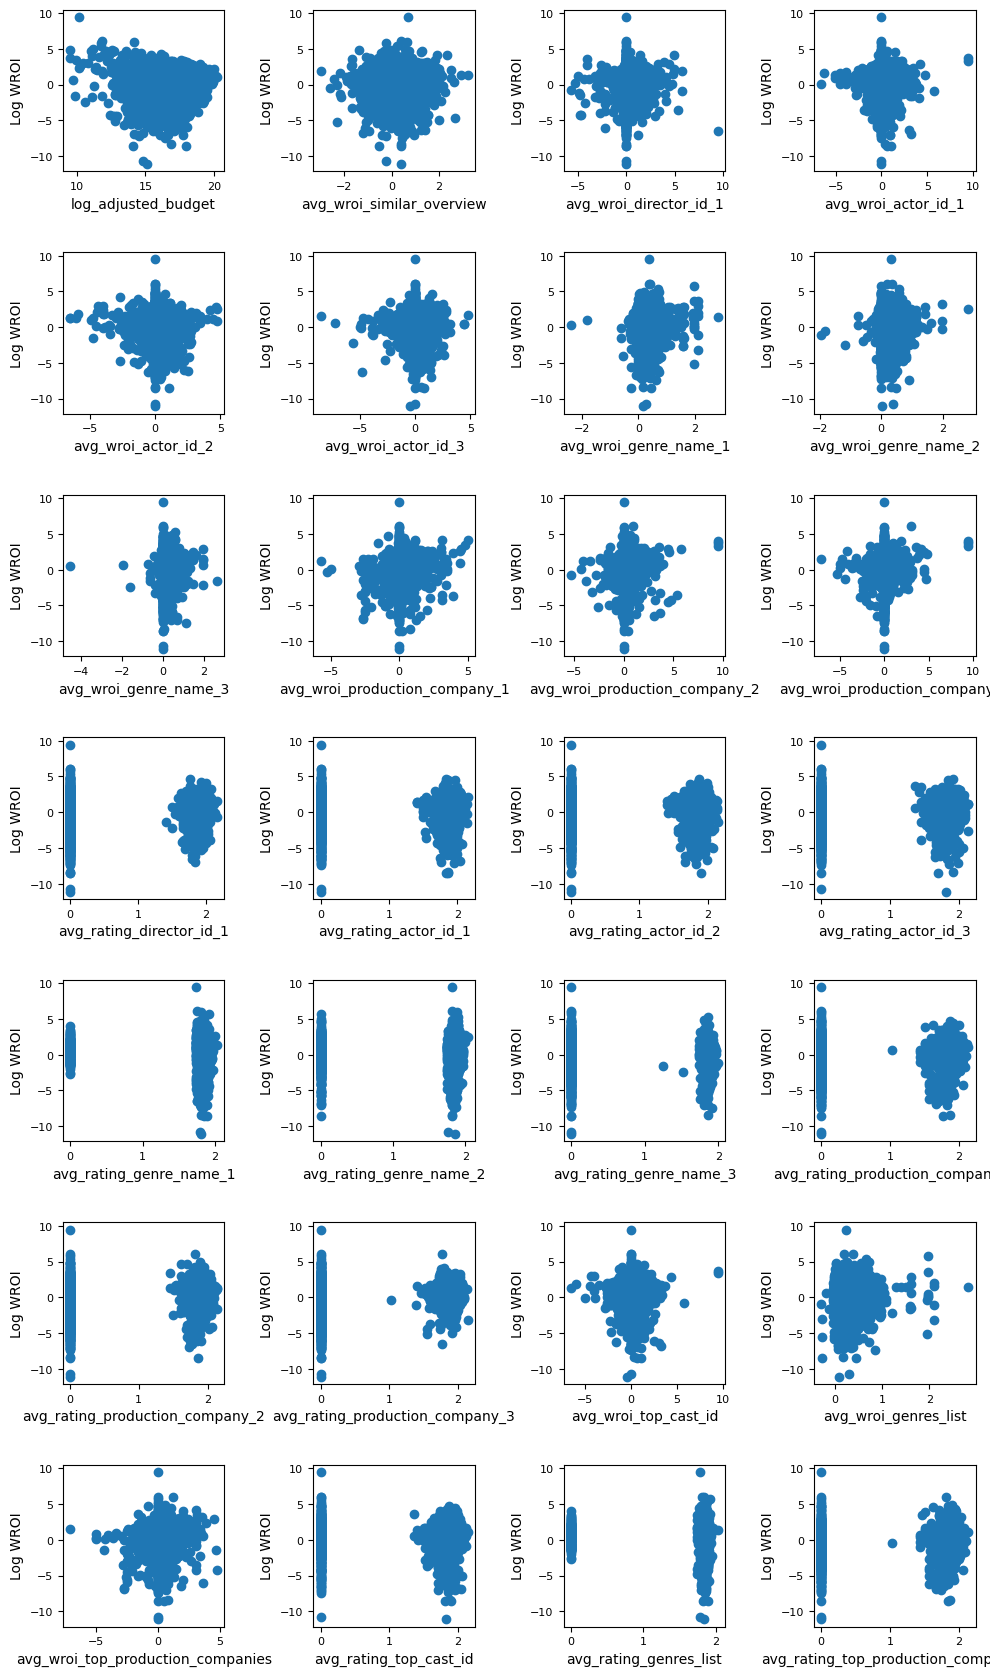

In [5]:
# Inspect distribution of observables
select_vars = predictors

fig, axs = plt.subplots(len(select_vars) // 4, 4, figsize=(3*4, 3*len(select_vars) // 4), sharex=False, sharey=False)
input_data = processed_data[select_vars + ['year'] + outputs]

for i, ax in enumerate(axs.flat):
    if i < len(select_vars):
        ax.scatter(input_data[select_vars[i]], input_data[outputs]);
        ax.minorticks_off()
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_box_aspect(1)
        ax.set_ylabel('Log WROI', fontsize = 10)
        ax.set_xlabel(select_vars[i], fontsize = 10)

fig.subplots_adjust(wspace=.4, hspace=.5)

Need to scale variables, and figure out how to measure performance.

### Linear regression

Year: 2001.0 RMSE: 1.2753021872387849 Score: -0.08149366698970262
Year: 2002.0 RMSE: 1.4284036187406821 Score: 0.027920348230129455
Year: 2003.0 RMSE: 1.25889483415646 Score: -0.07902790858614273
Year: 2004.0 RMSE: 1.4926110788696032 Score: -0.00408761479552977
Year: 2005.0 RMSE: 1.79414126338317 Score: 0.04123855202034443
Year: 2006.0 RMSE: 1.6722539410143162 Score: 0.12123827394953457
Year: 2007.0 RMSE: 1.6756452957211923 Score: 0.07796643262239722
Year: 2008.0 RMSE: 1.5353272993444 Score: -0.005582553382308397
Year: 2009.0 RMSE: 1.703239186327068 Score: 0.051195676011773994
Year: 2010.0 RMSE: 1.6307480247743653 Score: 0.13818458736915462
Year: 2011.0 RMSE: 1.3627607736684517 Score: 0.18100026556037296
Year: 2012.0 RMSE: 1.588908900960681 Score: 0.14743434195854532
Year: 2013.0 RMSE: 1.583931223399823 Score: 0.12048622692491662
Year: 2014.0 RMSE: 1.8231174475203382 Score: 0.20507383544854774
Year: 2015.0 RMSE: 2.1388945491634312 Score: 0.09817082145729006
Best alpha: 0.01 rmse: 1.596

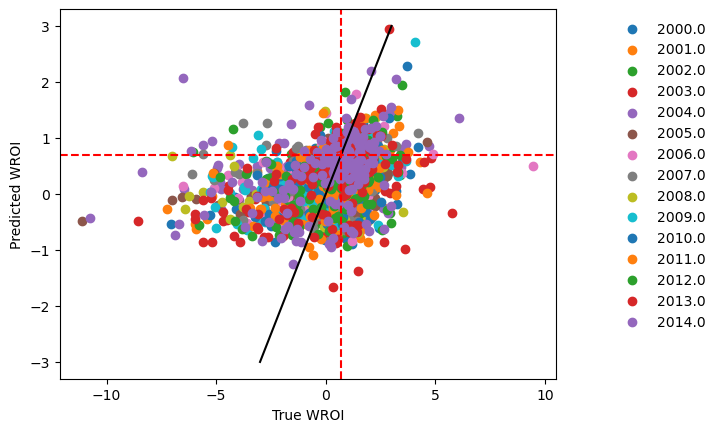

In [17]:
alphas = [0.000001,.00001,.0001,.001,.01,.1,.25,.5,.75,1,5]
years = np.unique(processed_data.loc[(processed_data.year >= 2000)].year)
store_alphas = []

for year in years[:-1]:
    # Split data by time
    train_data = processed_data.loc[(processed_data.year <= year)]
    val_data = processed_data.loc[processed_data.year == year + 1]
    # Scale data
    scaler = StandardScaler()
    train_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())
    val_predictors_scaled = scaler.transform(val_data[predictors].to_numpy())
    # Run regression
    coefs = np.zeros((len(alphas), len(predictors) + 4))
    for i in range(len(alphas)):
        ## make lasso model
        lr = linear_model.Lasso(alpha=alphas[i], max_iter=10000000)
        ## record coefs
        lr.fit(train_predictors_scaled, train_data[outputs])
        coefs[i,0:len(predictors)] = lr.coef_
        # Compute score
        val_prediction = lr.predict(val_predictors_scaled)
        rmse = np.sqrt(mean_squared_error(val_data[outputs], val_prediction))
        score = lr.score(val_predictors_scaled, val_data[outputs])
        coefs[i,-4] = rmse
        coefs[i,-3] = score
        coefs[i,-2] = year
        coefs[i,-1] = alphas[i]

        # Visualize performance
        if i == 0:
            print("Year:", year + 1, "RMSE:", rmse, "Score:", score)
            plt.scatter(val_data[outputs], val_prediction, label = str(year))
    #  Store data
    store_alphas.append(coefs)

# Model selection
## use dataframe to look at coefs
df_alpha = pd.DataFrame(data=np.vstack(store_alphas), 
                  columns=predictors + ['rmse', 'score', 'year', 'alpha']).groupby('alpha', as_index = False).mean()
opt_alpha = df_alpha.alpha.values[np.argmin(df_alpha.rmse.values)]
opt_alpha_rmse = df_alpha.rmse.values[np.argmin(df_alpha.rmse.values)]
print("Best alpha:", opt_alpha, "rmse:", opt_alpha_rmse)

plt.plot(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20), color = 'black')
plt.xlabel("True WROI")
plt.ylabel("Predicted WROI")
plt.axhline(y = np.log(2), linestyle = '--', color = 'red')
plt.axvline(x = np.log(2), linestyle = '--', color = 'red')
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=10, framealpha=0, ncol = 1)

In [10]:
# Feature selection
## use dataframe to look at coefs
df_alpha = pd.DataFrame(data=np.vstack(store_alphas), 
                  columns=predictors + ['rmse', 'score', 'year', 'alpha']).groupby('alpha', as_index = True).mean()

# This shows the first value of alpha where the parameter for the feature was set to zero.
df_alpha[predictors].ne(0).idxmin().sort_values(ascending=False)

avg_rating_top_production_companies    0.50
avg_wroi_top_production_companies      0.50
avg_rating_genre_name_1                0.25
avg_rating_genres_list                 0.25
avg_rating_top_cast_id                 0.25
avg_wroi_production_company_1          0.25
avg_wroi_production_company_2          0.25
avg_wroi_production_company_3          0.25
avg_rating_production_company_1        0.25
avg_wroi_genres_list                   0.10
avg_wroi_top_cast_id                   0.10
avg_rating_production_company_3        0.10
avg_rating_production_company_2        0.10
avg_rating_genre_name_3                0.10
avg_rating_genre_name_2                0.10
log_adjusted_budget                    0.10
avg_rating_actor_id_3                  0.10
avg_wroi_similar_overview              0.10
avg_rating_actor_id_1                  0.10
avg_rating_director_id_1               0.10
avg_wroi_genre_name_3                  0.10
avg_wroi_genre_name_2                  0.10
avg_wroi_genre_name_1           

In [11]:
# Need to figure out which covariates are most important -> feature selection ala Lasso
# Build content-based covariate
# Include keywords and attempt similarity matching: ROI**(similarity score)

### KNN regression

Year: 2001.0 RMSE: 1.275708652332396 Score: -0.08218316549773874
Year: 2002.0 RMSE: 1.449254495359249 Score: -0.000666316131469058
Year: 2003.0 RMSE: 1.2556103178271296 Score: -0.07340478368821746
Year: 2004.0 RMSE: 1.5032820207637745 Score: -0.018495736101062477
Year: 2005.0 RMSE: 1.7976675526797596 Score: 0.03746605900495292
Year: 2006.0 RMSE: 1.6883153253445755 Score: 0.1042768424551499
Year: 2007.0 RMSE: 1.6647651742121252 Score: 0.08990125969544294
Year: 2008.0 RMSE: 1.5217865088914784 Score: 0.012076662249455805
Year: 2009.0 RMSE: 1.677029031537392 Score: 0.08017218905477264
Year: 2010.0 RMSE: 1.6106481626648004 Score: 0.1592983546022323
Year: 2011.0 RMSE: 1.3953055600973774 Score: 0.1414152658915815
Year: 2012.0 RMSE: 1.633047125990466 Score: 0.09940968045134757
Year: 2013.0 RMSE: 1.5811703042144103 Score: 0.12354968079521933
Year: 2014.0 RMSE: 1.8011196265252283 Score: 0.22414133564045602
Year: 2015.0 RMSE: 2.1244151037516272 Score: 0.11033952583826456
Best k: 33.0 rmse: 1.5929

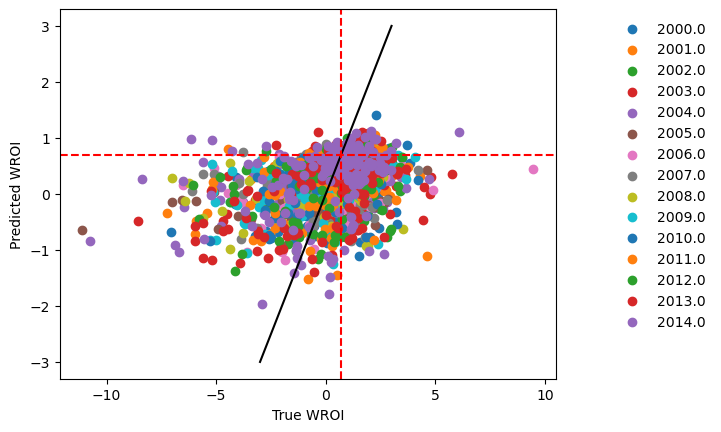

In [13]:
ks = np.arange(1, 50)
store_ks = []

for year in years[:-1]:
    # Split data by time
    train_data = processed_data.loc[(processed_data.year <= year)]
    val_data = processed_data.loc[processed_data.year == year + 1]
    # Scale data
    scaler = StandardScaler()
    train_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())
    val_predictors_scaled = scaler.transform(val_data[predictors].to_numpy())
    # Run regression
    coefs = np.zeros((len(ks), 4))
    for i in range(len(ks)):
        ## make lasso model
        neigh = KNeighborsRegressor(n_neighbors=ks[i]).fit(train_predictors_scaled, train_data[outputs])
        ## record coefs
        # Compute score
        val_prediction = neigh.predict(val_predictors_scaled)
        rmse = np.sqrt(mean_squared_error(val_data[outputs], val_prediction))
        score = neigh.score(val_predictors_scaled, val_data[outputs])
        coefs[i,3] = rmse
        coefs[i,2] = score
        coefs[i,1] = year
        coefs[i,0] = ks[i]

        # Visualize performance
        if i == len(ks) - 1:
            print("Year:", year + 1, "RMSE:", rmse, "Score:", score)
            plt.scatter(val_data[outputs], val_prediction, label = str(year))
    #  Store data
    store_ks.append(coefs)

# Model selection
## use dataframe to look at coefs
df_k = pd.DataFrame(data=np.vstack(store_ks), 
                  columns=['k', 'year','score', 'rmse']).groupby('k', as_index = False).mean()
opt_k = df_k.k.values[np.argmin(df_k.rmse.values)]
opt_k_rmse = df_k.rmse.values[np.argmin(df_k.rmse.values)]
print("Best k:", opt_k, "rmse:", opt_k_rmse)

plt.plot(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20), color = 'black')
plt.xlabel("True WROI")
plt.ylabel("Predicted WROI")
plt.axhline(y = np.log(2), linestyle = '--', color = 'red')
plt.axvline(x = np.log(2), linestyle = '--', color = 'red')
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=10, framealpha=0, ncol = 1)

### Model selection

RMSE = 1.621603452351102


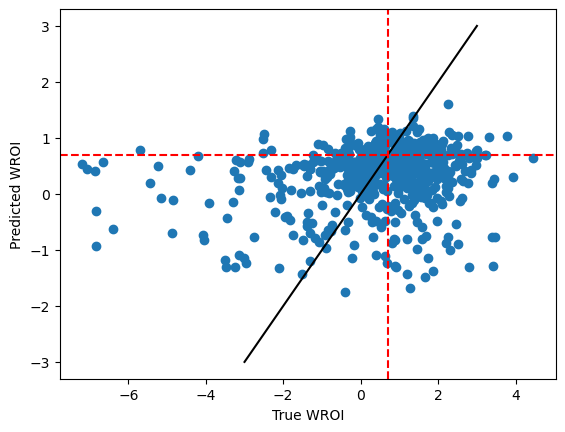

In [20]:
# Split data by time
train_data = processed_data

# Scale data
scaler = StandardScaler()
train_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())
test_predictors_scaled = scaler.transform(test_data[predictors].to_numpy())

# Run regression
## make lasso model
if opt_k_rmse <= opt_alpha_rmse:
    model = KNeighborsRegressor(n_neighbors=int(opt_k)).fit(train_predictors_scaled, train_data[outputs])
else:
    model = linear_model.Lasso(alpha=opt_alpha, max_iter=10000000).fit(train_predictors_scaled, train_data[outputs])

# Compute score
test_prediction = model.predict(test_predictors_scaled)
rmse = np.sqrt(mean_squared_error(test_data[outputs], test_prediction))
score = model.score(test_predictors_scaled, test_data[outputs])

# Visualize performance
plt.scatter(test_data[outputs], test_prediction)

plt.plot(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20), color = 'black')
plt.xlabel("True WROI")
plt.ylabel("Predicted WROI")
plt.axhline(y = np.log(2), linestyle = '--', color = 'red')
plt.axvline(x = np.log(2), linestyle = '--', color = 'red')

print("RMSE =", rmse)

In [47]:
look_at_ = ['title','budget', 'worldwide_boxoffice', 'year','release_date', 'wroi', 'avg_wroi_top_production_companies', 'avg_wroi_top_cast_id','top_production_companies', 'top_cast']
under_performers = test_data.loc[(test_data[outputs].values.ravel() <= np.log(2))*(test_prediction.ravel() > np.log(2))][look_at_]
under_performers

,title,budget,worldwide_boxoffice,year,release_date,wroi,avg_wroi_top_production_companies,avg_wroi_top_cast_id,top_production_companies,top_cast
213,Alice Through the Looking Glass,170000000.0,276928112.0,2016.0,2016-05-20,1.628989,0.861107,0.824332,"['Legend3D', 'Walt Disney Pictures', 'Roth Fil...","['Mia Wasikowska', 'Johnny Depp', 'Anne Hathaw..."
234,All My Life,25000000.0,2024063.0,2020.0,2020-10-23,0.080963,0.884907,0.031913,"['Broken Road Productions', 'Perfect World Pic...","['Jessica Rothe', 'Harry Shum Jr.', 'Michael M..."
305,A Monster Calls,43000000.0,46414530.0,2016.0,2016-10-07,1.079408,0.568492,-0.957726,"['River Road Entertainment', 'Participant', 'A...","['Lewis MacDougall', 'Sigourney Weaver', 'Feli..."
599,Battle of the Sexes,25000000.0,18445379.0,2017.0,2017-09-22,0.737815,0.672047,0.957427,"['Fox Searchlight Pictures', 'Decibel Films', ...","['Emma Stone', 'Steve Carell', 'Andrea Risebor..."
654,Ben-Hur,95000000.0,91669648.0,2016.0,2016-06-30,0.964944,1.129752,0.571155,"['Metro-Goldwyn-Mayer', 'Paramount Pictures', ...","['Jack Huston', 'Pilou Asbæk', 'Rodrigo Santor..."
...,...,...,...,...,...,...,...,...,...,...
6056,The Trial of the Chicago 7,35000000.0,116473.0,2020.0,2020-10-02,0.003328,0.260818,0.843783,"['DreamWorks Pictures', 'Marc Platt Productions']","['Eddie Redmayne', 'Sacha Baron Cohen', 'Mark ..."
6060,The Turning,12000000.0,18460739.0,2020.0,2020-01-23,1.538395,1.158875,-0.471833,"['DreamWorks Pictures', 'Universal Pictures', ...","['Mackenzie Davis', 'Finn Wolfhard', 'Brooklyn..."
6108,The Way Back,23000000.0,15490514.0,2020.0,2020-03-05,0.673501,0.866845,0.713508,"['Warner Bros. Pictures', 'Pearl Street Films'...","['Ben Affleck', 'Al Madrigal', 'Michaela Watki..."
6376,Unforgettable,12000000.0,17768012.0,2017.0,2017-04-20,1.480668,1.437871,0.604008,"['Di Novi Pictures', 'RatPac Entertainment']","['Rosario Dawson', 'Katherine Heigl', 'Geoff S..."


In [48]:
over_performers = test_data.loc[(test_data[outputs].values.ravel() > np.log(2))*(test_prediction.ravel() <= np.log(2))][look_at_]
over_performers

,title,budget,worldwide_boxoffice,year,release_date,wroi,avg_wroi_top_production_companies,avg_wroi_top_cast_id,top_production_companies,top_cast
4,10 Cloverfield Lane,15000000.0,108286422.0,2016.0,2016-01-04,7.219095,0.954344,0.514770,['Bad Robot'],"['John Goodman', 'Mary Elizabeth Winstead', 'J..."
14,12 Strong,35000000.0,71118378.0,2018.0,2018-01-16,2.031954,0.937203,0.130522,"['Torridon Films', 'Alcon Entertainment', 'Bla...","['Chris Hemsworth', 'Michael Shannon', 'Michae..."
71,47 Meters Down,5300000.0,62633705.0,2017.0,2017-05-26,11.817680,0.000000,0.052530,"['Lantica Media', 'Flexibon Films', 'Dragon Ro...","['Mandy Moore', 'Claire Holt', 'Matthew Modine..."
72,47 Meters Down: Uncaged,12000000.0,47582563.0,2019.0,2019-08-15,3.965214,-0.987310,1.387435,"['The Fyzz', 'Entertainment Studios']","['Sophie Nélisse', 'Corinne Foxx', 'Brianne Tj..."
99,A Bad Moms Christmas,28000000.0,127710550.0,2017.0,2017-11-01,4.561091,0.475809,0.680132,"['STXfilms', 'Robert Simonds Productions', 'Su...","['Mila Kunis', 'Kristen Bell', 'Kathryn Hahn',..."
...,...,...,...,...,...,...,...,...,...,...
6607,Wind River,11000000.0,44984979.0,2017.0,2017-06-16,4.089544,1.047252,0.374803,"['Savvy Media Holdings', 'Thunder Road', 'Film...","['Jeremy Renner', 'Elizabeth Olsen', 'Gil Birm..."
6642,Wonder Woman,150000000.0,817691766.0,2017.0,2017-05-29,5.451278,0.457076,0.603901,"['Atlas Entertainment', 'Cruel & Unusual Films...","['Gal Gadot', 'Chris Pine', 'Connie Nielsen', ..."
6673,xXx: Return of Xander Cage,85000000.0,346118277.0,2017.0,2017-01-13,4.071980,0.000000,1.417863,"['Rox Productions', 'Revolution Studios', 'Map...","['Vin Diesel', 'Donnie Yen', 'Ruby Rose', 'Ton..."
6724,Zombieland: Double Tap,48000000.0,125213018.0,2019.0,2019-10-09,2.608605,0.771738,1.307303,"['Pariah', 'Columbia Pictures', '2.0 Entertain...","['Woody Harrelson', 'Jesse Eisenberg', 'Emma S..."


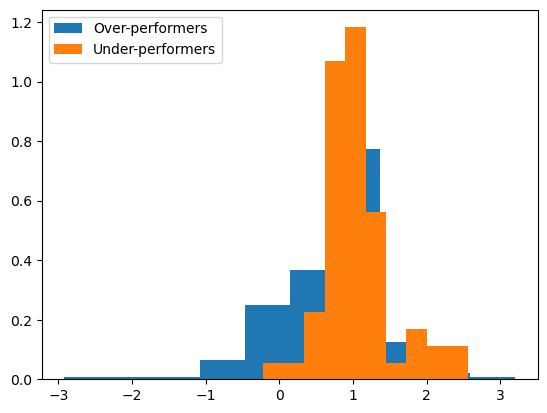

In [46]:
plt.hist(over_performers['avg_wroi_top_production_companies'], density = True, label = "Over-performers")
plt.hist(under_performers['avg_wroi_top_production_companies'], density = True, label = "Under-performers")
plt.legend()

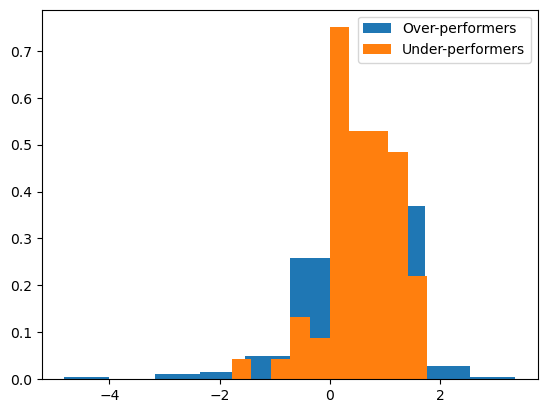

In [49]:
plt.hist(over_performers['avg_wroi_top_cast_id'], density = True, label = "Over-performers")
plt.hist(under_performers['avg_wroi_top_cast_id'], density = True, label = "Under-performers")
plt.legend()

### Logistic regression

In [ ]:
for year in years[:-1]:
    # Split data by time
    train_data = processed_data.loc[(processed_data.year <= year)]
    val_data = processed_data.loc[processed_data.year == year + 1]
    # Scale data
    scaler = StandardScaler()
    train_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())
    val_predictors_scaled = scaler.transform(val_data[predictors].to_numpy())
    # Run regression
    clf = linear_model.LogisticRegression(random_state=0).fit(train_predictors_scaled,
                                                              train_data[outputs].values.ravel() >= np.log(2))
    # Compute score
    val_prediction = clf.predict(val_predictors_scaled)
    print("Year:", year, "Score:", clf.score(val_predictors_scaled, val_data[outputs] >= np.log(2)))
    # Visualize performance
    plt.scatter(1*(val_data[outputs].values.ravel() >= np.log(2)), clf.predict(val_predictors_scaled), label = str(year))

plt.xlabel("True WROI")
plt.ylabel("Predicted WROI")
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=10, framealpha=0, ncol = 2)